
# Final Project — Environmental Data Analysis with Python
**Dataset:** Terminos Lagoon (TA & DIC), field survey (n≈100)

**Author:** Adua Sofía Olvera Avila  
**Course:** Environmental Data Analysis with Python  


---
## Introduction

The National Commission of Natural Protected Areas (CONANP) is responsible for the administration of Mexico’s parks and reserves, and has pioneered ecosystem-based management strategies. In 1994, the Terminos Lagoon was designated as a Protected Area of Flora and Fauna, incorporating the lower basins of the Candelaria, Chumpan, and Palizada rivers. The protected boundaries also neighbor the Pantanos de Centla Biosphere Reserve (created in 1992), with both reserves jointly covering more than 1,007,723 hectares managed by a small CONANP team (Bach et al., 2005).

Coastal-estuarine environments represent dynamic ecological transition zones between continental and marine waters. They are characterized by high spatiotemporal heterogeneity in physicochemical properties (e.g., salinity, dissolved oxygen, nutrients, organic matter) and sustain remarkable biological productivity (Kennish, 2002). Within this framework, Terminos Lagoon is influenced by freshwater inflow from major rivers and by marine exchange through its inlets, producing strong gradients that structure ecosystem function.

The present study focuses on comparing two major riverine systems of the lagoon — Candelaria and Palizada — including their respective River, Plume, and Coastal zones. We aim to (i) evaluate differences in carbonate chemistry (Total Alkalinity, Dissolved Inorganic Carbon) and hydrographic parameters (temperature, salinity, dissolved oxygen, turbidity), and (ii) identify whether multivariate ordination and clustering reveal distinct hydrographic regimes associated with each river system.

## Abstract
This project analyzes carbonate-system and hydrographic variables (Total Alkalinity, Dissolved Inorganic Carbon, temperature, salinity, dissolved oxygen, turbidity, conductance) from the Terminos Lagoon region. I perform descriptive statistics, normality tests, non‑parametric comparisons, two‑way ANOVA, linear regression, correlation analysis, PCA, and K‑means clustering. Figures follow a clean, publication‑oriented style using matplotlib.

## Reproducibility
All code uses standard scientific Python libraries.
- Python (3.x)
- Jupyter Notebook
- pandas
- numpy
- matplotlib
- scipy
- statsmodels
- scikit-learn


## Objectives

**Primary objective.**  
Quantify hydrographic and carbonate‐system differences between the Candelaria and Palizada sectors of Terminos Lagoon across their three zones: River, Plume, and Coast.

**Secondary objectives.**
1. Compare the distributions of salinity (PSU), temperature (°C), total alkalinity (TA; µmol kg⁻¹), and dissolved inorganic carbon (DIC; µmol kg⁻¹) between estuaries within each zone (River/Plume/Coast), and estimate effect sizes.
2. Test for main effects of estuary and zone, and their interaction on temperature (and, where appropriate, other variables).
3. Characterize multivariate structure of hydrographic and carbonate variables using PCA, evaluating whether sample scores segregate by estuary and/or zone.
4. Assess the strength and form of the DIC–TA relationship and whether it differs by estuary or zone.

In [158]:

# Setup
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Stats & ML
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [ ]:

# Paths

#This section will try to find the Data File Path. 
def resolve_data_path() -> Path:
    candidates = [
        #Data file Path
        Path("/Users/adua/Python-para-an-lisis-de-biodiversidad_AgoSep2025/data/Terminos_lagoon_TA_DIC_2023_RawData.csv"),  
    ]
    for p in candidates:
        if p.exists():
            return p

DATA = resolve_data_path()
OUT = Path("figures"); OUT.mkdir(parents=True, exist_ok=True)



In [186]:
# Load 
df = pd.read_csv(DATA)
print(f"Using data file: {DATA.resolve()}")
print("Shape:", df.shape)
df.head()



Using data file: /Users/adua/Python-para-an-lisis-de-biodiversidad_AgoSep2025/data/Terminos_lagoon_TA_DIC_2023_RawData.csv
Shape: (106, 21)


,sample,date,estuary,area,station,layer_depth,season,chlorophy_microg_l,cond_microsiemens_cm,depth_m,...,do_mg_l,sal_psu,sp_cond_microsiemens_cm,turbidity_fnu,temp_c,latitude,longitude,dic_micromol_kg,ta_micromol_kg,dummy_data
0,CDL01S,5/3/2020,Candelaria,River,CDL01,Surface,Dry,0.36,7015.4,0.464,...,7.12,3.56,6547.7,1.47,28.740,18.55736,-91.25012,3915,3863,3685.0
1,CDL01F,5/3/2020,Candelaria,River,CDL01,Bottom,Dry,4.19,29886.1,7.792,...,4.90,16.97,27751.2,95.33,29.028,18.55722,-91.24990,3698,3685,NaN
2,CDL02S,5/3/2020,Candelaria,River,CDL02,Surface,Dry,0.92,16691.1,0.453,...,6.99,8.94,15429.1,5.50,29.283,18.61007,-91.24410,3724,3708,3708.0
3,CDL02F,5/3/2020,Candelaria,River,CDL02,Bottom,Dry,2.23,24847.4,1.261,...,6.52,13.87,23074.0,13.44,29.024,18.61005,-91.24403,3667,3992,3992.0
4,CDL03S,5/3/2020,Candelaria,River,CDL03,Surface,Dry,0.58,46341.6,0.465,...,6.24,28.06,43670.8,3.60,28.202,18.63166,-91.29359,2928,3023,3023.0


In [161]:

# Overview 
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols     = df.select_dtypes(exclude=[np.number]).columns.tolist()

summary = {
    "Total rows": len(df),
    "Total cols": df.shape[1],
    "Numeric cols": numeric_cols,
    "Categorical cols": cat_cols,
    "Missing counts": {col: int(n) for col, n in df.isna().sum().items() if n > 0},
}
summary


{'Total rows': 106,
 'Total cols': 21,
 'Numeric cols': ['chlorophy_microg_l',
  'cond_microsiemens_cm',
  'depth_m',
  'do_percent_sat',
  'do_mg_l',
  'sal_psu',
  'sp_cond_microsiemens_cm',
  'turbidity_fnu',
  'temp_c',
  'latitude',
  'longitude',
  'dic_micromol_kg',
  'ta_micromol_kg',
  'dummy_data'],
 'Categorical cols': ['sample',
  'date',
  'estuary',
  'area',
  'station',
  'layer_depth',
  'season'],
 'Missing counts': {'dummy_data': 7}}

In [162]:

# Descriptive statistics
desc = df.describe(include="all").T
desc


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
sample,106,36,CDL01S,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,106,6,5/3/2020,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
estuary,106,2,Palizada,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
area,106,3,Coast,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
station,106,18,CDL01,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
layer_depth,106,2,Surface,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,106,2,Dry,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chlorophy_microg_l,106.0,NaN,NaN,NaN,6.545472,14.941262,0.36,2.555,3.705,5.925,150.9
cond_microsiemens_cm,106.0,NaN,NaN,NaN,27895.183962,20931.232513,13.8,1778.025,33202.6,47046.65,59988.6
depth_m,106.0,NaN,NaN,NaN,1.83016,2.038739,0.105,0.42875,0.6385,2.88325,8.558


In [ ]:

# Missing values handling
# Strategy: keep rows with at least one of the target variables
targets = ["dic_micromol_kg","ta_micromol_kg","temp_c","sal_psu","do_mg_l","turbidity_fnu"]

df_clean = df.copy()
# Simple imputation for demo (median) on numeric columns
for c in numeric_cols:
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())

df_clean = df_clean.dropna(subset=["layer_depth","area","estuary"])
df_clean.shape

(106, 21)

In [164]:
df_clean.head()

,sample,date,estuary,area,station,layer_depth,season,chlorophy_microg_l,cond_microsiemens_cm,depth_m,...,do_mg_l,sal_psu,sp_cond_microsiemens_cm,turbidity_fnu,temp_c,latitude,longitude,dic_micromol_kg,ta_micromol_kg,dummy_data
0,CDL01S,5/3/2020,Candelaria,River,CDL01,Surface,Dry,0.36,7015.4,0.464,...,7.12,3.56,6547.7,1.47,28.740,18.55736,-91.25012,3915,3863,3685.0
1,CDL01F,5/3/2020,Candelaria,River,CDL01,Bottom,Dry,4.19,29886.1,7.792,...,4.90,16.97,27751.2,95.33,29.028,18.55722,-91.24990,3698,3685,2814.0
2,CDL02S,5/3/2020,Candelaria,River,CDL02,Surface,Dry,0.92,16691.1,0.453,...,6.99,8.94,15429.1,5.50,29.283,18.61007,-91.24410,3724,3708,3708.0
3,CDL02F,5/3/2020,Candelaria,River,CDL02,Bottom,Dry,2.23,24847.4,1.261,...,6.52,13.87,23074.0,13.44,29.024,18.61005,-91.24403,3667,3992,3992.0
4,CDL03S,5/3/2020,Candelaria,River,CDL03,Surface,Dry,0.58,46341.6,0.465,...,6.24,28.06,43670.8,3.60,28.202,18.63166,-91.29359,2928,3023,3023.0


## Methods (key formulas)

**Simple linear regression.** We fit $ y = \beta_0 + \beta_1 x + \varepsilon $ by OLS, with
$$
\hat{\beta}_1=\frac{\sum_i (x_i-\bar x)(y_i-\bar y)}{\sum_i (x_i-\bar x)^2}, 
\quad 
\hat{\beta}_0=\bar y-\hat{\beta}_1 \bar x.
$$

**Shapiro–Wilk test.** Tests normality via
$$
W=\frac{\left(\sum_{i=1}^n a_i x_{(i)}\right)^2}{\sum_{i=1}^n (x_i-\bar x)^2},
$$
where $x_{(i)}$ are order statistics and $a_i$ constants from the covariance of the normal order stats.

**Brown–Forsythe (Levene, median-centered).** With groups $j=1,\dots,g$: 
$z_{ij} = |x_{ij} - \tilde x_j|$, and perform one-way ANOVA on $z_{ij}$ to test variance equality.

**Spearman’s rank correlation.**
$$
\rho = 1 - \frac{6 \sum_i d_i^2}{n(n^2-1)},
$$
with $d_i$ rank differences.

**PCA (standardized X).** Decompose $ \mathbf{X}_s = \mathbf{U}\mathbf{S}\mathbf{V}^\top$;
loadings are eigenvectors in $\mathbf{V}$; explained variance ratios are $S_k^2 / \sum_\ell S_\ell^2$.



In [165]:

# Normality tests (Shapiro-Wilk)
norm_results = []
for var in ["dic_micromol_kg","ta_micromol_kg","temp_c","sal_psu","do_mg_l","turbidity_fnu"]:
    if var in df_clean.columns:
        x = df_clean[var].dropna().astype(float)
        if len(x) >= 3:
            w, p = stats.shapiro(x.sample(min(500, len(x)), random_state=42))  # cap for speed
            norm_results.append({"variable": var, "W": w, "p_value": p, "n": len(x)})
pd.DataFrame(norm_results)

,variable,W,p_value,n
0,dic_micromol_kg,0.859974,1.383694e-08,106
1,ta_micromol_kg,0.879711,9.071436e-08,106
2,temp_c,0.960102,2.876702e-03,106
3,sal_psu,0.886664,1.838850e-07,106
4,do_mg_l,0.878661,8.170418e-08,106
5,turbidity_fnu,0.345526,1.268250e-19,106


In [ ]:
# Assumption checks (by estuary within zone)
# Goal: to compare Candelaria vs Palizada within each zone (River/Plume/Coast)

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# Objectives defined
keep_est  = ["Candelaria","Palizada"]
keep_area = ["River","Plume","Coast"]

dfe = (
    df_clean
      .assign(estuary=lambda x: x["estuary"].astype(str).str.strip(),
              area=lambda x: x["area"].astype(str).str.strip())
      .query("estuary in @keep_est and area in @keep_area")
      .reset_index(drop=True)
)

vars_core  = ["sal_psu","temp_c","dic_micromol_kg","ta_micromol_kg"]
vars_extra = ["do_mg_l","turbidity_fnu"]
vars_all   = [v for v in vars_core + vars_extra if v in dfe.columns]

# Helpers
def _normality_1d(x):
    """Shapiro (n>=3), Anderson–Darling (flag 5%)."""
    x = pd.Series(x).dropna().astype(float).values
    n = len(x)
    out = {"n": n, "shapiro_W": np.nan, "shapiro_p": np.nan,
           "anderson_A2": np.nan, "anderson_reject_5pct": np.nan}
    if n >= 3:
        W, p = stats.shapiro(x if n <= 500 else x[:500])
        out.update({"shapiro_W": W, "shapiro_p": p})
    if n >= 3:
        ad = stats.anderson(x, dist="norm")
        # reject at 5%
        crit_5 = ad.critical_values[list(ad.significance_level).index(5.0)]
        out.update({"anderson_A2": ad.statistic,
                    "anderson_reject_5pct": float(ad.statistic > crit_5)})
    return out

# 1) Normality test
rows = []
for area in keep_area:
    sub = dfe[dfe["area"] == area]
    for var in vars_all:
        for est in keep_est:
            x = sub.loc[sub["estuary"] == est, var]
            res = _normality_1d(x)
            res.update({"area": area, "variable": var, "estuary": est})
            rows.append(res)

norm_by_group = pd.DataFrame(rows)
norm_by_group.to_csv(OUT/"normality_by_estuary_within_zone.csv", index=False)
norm_by_group.head(12)


,n,shapiro_W,shapiro_p,anderson_A2,anderson_reject_5pct,area,variable,estuary
0,17,0.806347,0.002482,1.357124,1.0,River,sal_psu,Candelaria
1,18,0.538936,0.000002,3.695609,1.0,River,sal_psu,Palizada
2,17,0.900276,0.068649,0.762604,1.0,River,temp_c,Candelaria
3,18,0.878162,0.024314,0.925603,1.0,River,temp_c,Palizada
4,17,0.858737,0.014617,1.010443,1.0,River,dic_micromol_kg,Candelaria
5,18,0.907504,0.077754,0.597095,0.0,River,dic_micromol_kg,Palizada
6,17,0.848442,0.010154,1.107526,1.0,River,ta_micromol_kg,Candelaria
7,18,0.847410,0.007711,1.067861,1.0,River,ta_micromol_kg,Palizada
8,17,0.883635,0.036432,0.625853,0.0,River,do_mg_l,Candelaria
9,18,0.873554,0.020371,1.127449,1.0,River,do_mg_l,Palizada


In [167]:
#2)Test for homogeneity of variances (Levene/Brown–Forsythe) comparing Candelaria and Palizada across zones
keep_est  = ["Candelaria","Palizada"]
keep_area = ["River","Plume","Coast"]

if "dfe" not in globals():
    dfe = (
        df_clean
        .assign(estuary=lambda x: x["estuary"].astype(str).str.strip(),
                area=lambda x: x["area"].astype(str).str.strip())
        .query("estuary in @keep_est and area in @keep_area")
        .reset_index(drop=True)
    )

vars_core  = ["sal_psu","temp_c","dic_micromol_kg","ta_micromol_kg"]
vars_extra = ["do_mg_l","turbidity_fnu"]
vars_all   = [v for v in vars_core + vars_extra if v in dfe.columns]

lev_rows = []

for area in keep_area:
    sub = dfe[dfe["area"] == area]
    for var in vars_all:
        g1 = sub.loc[sub["estuary"] == "Candelaria", var].dropna().astype(float).values
        g2 = sub.loc[sub["estuary"] == "Palizada",   var].dropna().astype(float).values
        if len(g1) >= 2 and len(g2) >= 2:
            stat, p = stats.levene(g1, g2, center="median")  # Brown–Forsythe
            lev_rows.append({
                "area": area, "variable": var,
                "levene_stat": float(stat), "levene_p": float(p),
                "n_Candelaria": int(len(g1)), "n_Palizada": int(len(g2))
            })


lev_by_zone = pd.DataFrame(lev_rows)
lev_by_zone.to_csv(OUT / "levene_by_zone_estuary.csv", index=False)
lev_by_zone.head(12)


,area,variable,levene_stat,levene_p,n_Candelaria,n_Palizada
0,River,sal_psu,18.227129,0.000156,17,18
1,River,temp_c,7.348378,0.010569,17,18
2,River,dic_micromol_kg,4.032551,0.052874,17,18
3,River,ta_micromol_kg,3.283195,0.079101,17,18
4,River,do_mg_l,0.232472,0.632880,17,18
5,River,turbidity_fnu,0.383983,0.539735,17,18
6,Plume,sal_psu,0.474880,0.495568,17,18
7,Plume,temp_c,1.022552,0.319272,17,18
8,Plume,dic_micromol_kg,2.421715,0.129203,17,18
9,Plume,ta_micromol_kg,1.970723,0.169712,17,18


**Assumption checks**

 For within-zone estuary contrasts, Shapiro–Wilk indicated frequent non-normality (notably in the River zone), and Levene’s test showed unequal variances for some variables (e.g., salinity and temperature in River). Consequently, I used Mann–Whitney with Cliff’s δ for River; in Plume, variance homogeneity held, but I retained Mann–Whitney unless both groups passed Shapiro (in which case a t-test with equal variances is justified). 



In [168]:
# Test selection table (by zone & variable) 
def choose_test(area, var):
    ng = norm_by_group.query("area == @area and variable == @var").copy()
    lv = lev_by_zone.query("area == @area and variable == @var")
    if len(ng) != 2 or len(lv) != 1:
        return "insufficient diagnostics"
    p_c = float(ng.loc[ng["estuary"]=="Candelaria","shapiro_p"].iloc[0])
    p_p = float(ng.loc[ng["estuary"]=="Palizada","shapiro_p"].iloc[0])
    p_lev = float(lv["levene_p"].iloc[0])
    normal = (p_c > 0.05) and (p_p > 0.05)
    equal_var = (p_lev > 0.05)
    if normal and equal_var:
        return "parametric (t-test, equal_var=True)"
    elif normal and not equal_var:
        return "parametric (Welch t-test, equal_var=False)"
    else:
        return "non-parametric (Mann–Whitney)"

rows = []
for area in ["River","Plume","Coast"]:
    for var in ["sal_psu","temp_c","dic_micromol_kg","ta_micromol_kg","do_mg_l","turbidity_fnu"]:
        if var in norm_by_group["variable"].unique():
            rows.append({"area": area, "variable": var, "recommended_test": choose_test(area, var)})
reco_table = pd.DataFrame(rows)
reco_table


,area,variable,recommended_test
0,River,sal_psu,non-parametric (Mann–Whitney)
1,River,temp_c,non-parametric (Mann–Whitney)
2,River,dic_micromol_kg,non-parametric (Mann–Whitney)
3,River,ta_micromol_kg,non-parametric (Mann–Whitney)
4,River,do_mg_l,non-parametric (Mann–Whitney)
5,River,turbidity_fnu,non-parametric (Mann–Whitney)
6,Plume,sal_psu,non-parametric (Mann–Whitney)
7,Plume,temp_c,"parametric (t-test, equal_var=True)"
8,Plume,dic_micromol_kg,"parametric (t-test, equal_var=True)"
9,Plume,ta_micromol_kg,non-parametric (Mann–Whitney)


In [169]:
# Two-way ANOVA: residual diagnostics 
# Fit
anova_model = smf.ols("temp_c ~ C(estuary) * C(area)", data=dfe).fit()

# Residual normality (Shapiro on residuals)
res = anova_model.resid
W_res, p_res = stats.shapiro(res if len(res) <= 500 else res.sample(500, random_state=42))
print(f"[ANOVA residuals] Shapiro W={W_res:.3f}, p={p_res:.4f}")

# Homoscedasticity across estuary×area cells (Levene on temp_c)
cells = []
for (e,a), grp in dfe.groupby(["estuary","area"], dropna=False):
    vals = grp["temp_c"].dropna().astype(float).values
    if len(vals) >= 2:
        cells.append(vals)
if len(cells) >= 2:
    stat_lv, p_lv = stats.levene(*cells, center="median")
    print(f"[ANOVA cells] Levene (Brown–Forsythe) stat={stat_lv:.3f}, p={p_lv:.4f}")

# QQ plot of residuals
fig = plt.figure(figsize=(5,5))
sm.qqplot(res, line="s", ax=plt.gca())
plt.title("ANOVA residuals — QQ plot")
plt.tight_layout()
(OUT / "assumption_checks").mkdir(exist_ok=True, parents=True)
fig.savefig(OUT / "assumption_checks" / "anova_residuals_qq.png", dpi=300)
plt.close(fig)


[ANOVA residuals] Shapiro W=0.980, p=0.1209
[ANOVA cells] Levene (Brown–Forsythe) stat=3.419, p=0.0068


In [170]:
# Estuary contrasts within zone: Candelaria vs Palizada
# Ojective: compare estuaries within River/Plume/Coast using the
# appropriate test based on assumptions (normality + equal variances).

def cliffs_delta(x, y):
    x = np.asarray(pd.Series(x).dropna().astype(float))
    y = np.asarray(pd.Series(y).dropna().astype(float))
    nx, ny = len(x), len(y)
    if nx == 0 or ny == 0:
        return np.nan
    more = sum((xi > y).sum() for xi in x)
    less = sum((xi < y).sum() for xi in x)
    return (more - less) / (nx * ny)

def shapiro_p(arr):
    arr = pd.Series(arr).dropna().astype(float).values
    if len(arr) < 3:
        return np.nan
    W, p = stats.shapiro(arr if len(arr) <= 500 else arr[:500])
    return float(p)

results = []

for area in keep_area:
    sub = dfe[dfe["area"] == area]
    for var in vars_all:
        x = sub.loc[sub["estuary"] == "Candelaria", var].dropna().astype(float).values
        y = sub.loc[sub["estuary"] == "Palizada",   var].dropna().astype(float).values
        if len(x) < 2 or len(y) < 2:
            continue

        # Assumptions
        p_shap_x = shapiro_p(x)
        p_shap_y = shapiro_p(y)
        equal_var_p = stats.levene(x, y, center="median").pvalue  # Brown–Forsythe

        normal_both = (p_shap_x > 0.05) and (p_shap_y > 0.05)
        equal_var   = equal_var_p > 0.05

        if normal_both and equal_var:
            # Student's t-test (equal variances)
            tstat, pval = stats.ttest_ind(x, y, equal_var=True)
            test = "t-test (equal_var=True)"
            effect = np.nan  # keeping effect sizes minimal to match syllabus
            center_x, center_y = np.mean(x), np.mean(y)
        elif normal_both and not equal_var:
            # Welch's t-test
            tstat, pval = stats.ttest_ind(x, y, equal_var=False)
            test = "Welch t-test (equal_var=False)"
            effect = np.nan
            center_x, center_y = np.mean(x), np.mean(y)
        else:
            # Non-parametric: Mann–Whitney + Cliff's delta
            U, pval = stats.mannwhitneyu(x, y, alternative="two-sided")
            tstat = U  # store U in tstat column for convenience
            test = "Mann–Whitney"
            effect = cliffs_delta(x, y)   # Cliff's δ
            center_x, center_y = np.median(x), np.median(y)

        results.append({
            "area": area,
            "variable": var,
            "test": test,
            "n_Candelaria": len(x),
            "n_Palizada": len(y),
            "center_Candelaria": float(center_x),
            "center_Palizada": float(center_y),
            "statistic": float(tstat),
            "p_value": float(pval),
            "levene_p": float(equal_var_p),
            "shapiro_p_Candelaria": float(p_shap_x) if not np.isnan(p_shap_x) else np.nan,
            "shapiro_p_Palizada": float(p_shap_y) if not np.isnan(p_shap_y) else np.nan,
            "cliffs_delta": float(effect) if test == "Mann–Whitney" else np.nan
        })

estuary_contrasts = pd.DataFrame(results)
estuary_contrasts.to_csv(OUT / "estuary_contrasts_by_zone.csv", index=False)
estuary_contrasts.sort_values(["area","variable"]).head(18)


,area,variable,test,n_Candelaria,n_Palizada,center_Candelaria,center_Palizada,statistic,p_value,levene_p,shapiro_p_Candelaria,shapiro_p_Palizada,cliffs_delta
14,Coast,dic_micromol_kg,t-test (equal_var=True),18,18,2420.277778,2522.833333,-1.828182,0.076308,0.958629,5.070265e-01,0.073598,NaN
16,Coast,do_mg_l,t-test (equal_var=True),18,18,6.706111,7.032778,-1.017581,0.316064,0.299313,2.058332e-01,0.116632,NaN
12,Coast,sal_psu,Mann–Whitney,18,18,34.145000,25.465000,247.000000,0.007500,0.239328,7.054479e-04,0.028436,0.524691
15,Coast,ta_micromol_kg,Mann–Whitney,18,18,2630.000000,2792.000000,114.000000,0.132832,0.027919,3.082761e-02,0.009924,-0.296296
13,Coast,temp_c,Welch t-test (equal_var=False),18,18,26.168667,26.511944,-1.182051,0.247094,0.014697,2.715177e-01,0.075211,NaN
17,Coast,turbidity_fnu,Mann–Whitney,18,18,6.870000,31.890000,69.000000,0.003427,0.947152,1.345902e-08,0.000018,-0.574074
8,Plume,dic_micromol_kg,t-test (equal_var=True),17,18,2543.294118,2728.833333,-2.044885,0.048909,0.129203,1.815583e-01,0.063242,NaN
10,Plume,do_mg_l,Mann–Whitney,17,18,6.990000,6.935000,173.500000,0.509131,0.661242,2.874156e-02,0.001670,0.133987
6,Plume,sal_psu,Mann–Whitney,17,18,22.600000,20.775000,202.000000,0.109435,0.495568,3.507074e-02,0.016690,0.320261
9,Plume,ta_micromol_kg,Mann–Whitney,17,18,2803.000000,2802.500000,134.000000,0.541442,0.169712,3.331174e-02,0.189087,-0.124183


In [171]:
estuary_contrasts.query("test == 'Mann–Whitney'")[[
    "area","variable","n_Candelaria","n_Palizada","center_Candelaria",
    "center_Palizada","statistic","p_value","cliffs_delta"
]]


,area,variable,n_Candelaria,n_Palizada,center_Candelaria,center_Palizada,statistic,p_value,cliffs_delta
0,River,sal_psu,17,18,3.560,0.315,282.0,0.000022,0.843137
1,River,temp_c,17,18,27.084,26.778,209.5,0.064544,0.369281
2,River,dic_micromol_kg,17,18,2973.000,3268.500,180.0,0.381742,0.176471
3,River,ta_micromol_kg,17,18,3023.000,3205.500,194.0,0.181321,0.267974
4,River,do_mg_l,17,18,6.520,7.090,170.5,0.574714,0.114379
5,River,turbidity_fnu,17,18,5.500,27.285,64.0,0.003490,-0.581699
6,Plume,sal_psu,17,18,22.600,20.775,202.0,0.109435,0.320261
9,Plume,ta_micromol_kg,17,18,2803.000,2802.500,134.0,0.541442,-0.124183
10,Plume,do_mg_l,17,18,6.990,6.935,173.5,0.509131,0.133987
11,Plume,turbidity_fnu,17,18,6.100,47.155,83.0,0.021800,-0.457516


In [172]:
estuary_contrasts.query("p_value < 0.05")[
    ["area","variable","test","p_value","cliffs_delta"]
]


,area,variable,test,p_value,cliffs_delta
0,River,sal_psu,Mann–Whitney,0.000022,0.843137
5,River,turbidity_fnu,Mann–Whitney,0.003490,-0.581699
8,Plume,dic_micromol_kg,t-test (equal_var=True),0.048909,NaN
11,Plume,turbidity_fnu,Mann–Whitney,0.021800,-0.457516
12,Coast,sal_psu,Mann–Whitney,0.007500,0.524691
17,Coast,turbidity_fnu,Mann–Whitney,0.003427,-0.574074


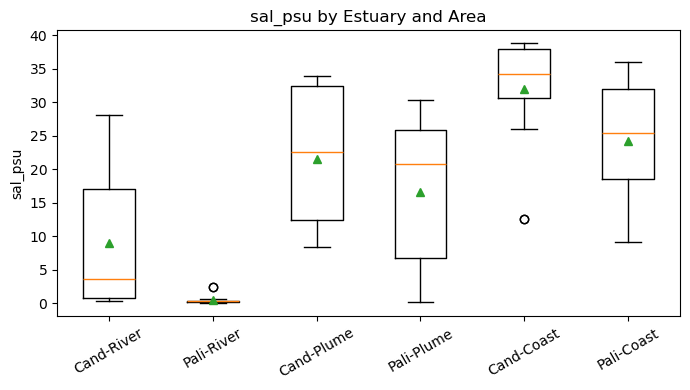

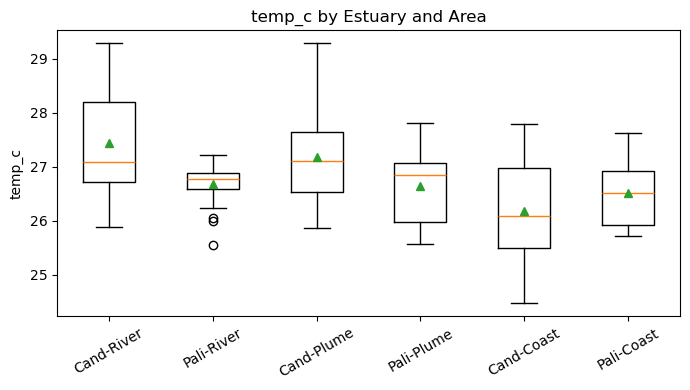

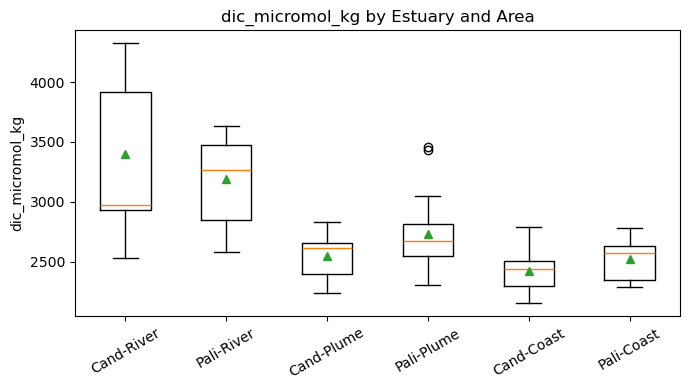

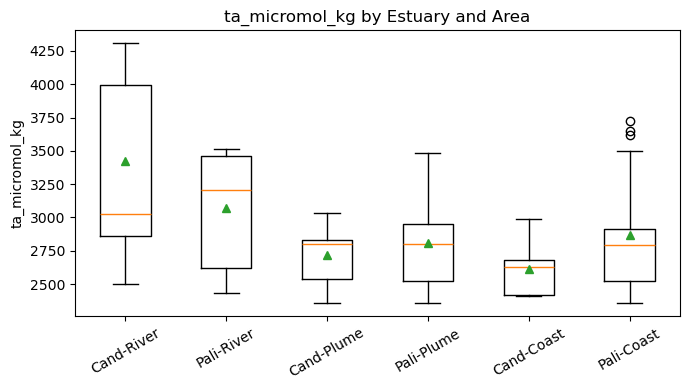

In [ ]:
# Boxplots: Candelaria vs Palizada on River/Plume/Coast
vars_box = [v for v in ["sal_psu","temp_c","dic_micromol_kg","ta_micromol_kg"] if v in dfe.columns]

def boxplot_by_group_inline(var):
    order = [
        ("Candelaria","River"), ("Palizada","River"),
        ("Candelaria","Plume"), ("Palizada","Plume"),
        ("Candelaria","Coast"), ("Palizada","Coast"),
    ]
    data = [dfe[(dfe["estuary"]==e) & (dfe["area"]==a)][var].dropna().astype(float).values for e,a in order]
    labels = [f"{e[:4]}-{a}" for e,a in order]
    fig, ax = plt.subplots(figsize=(7,4))
    ax.boxplot(data, tick_labels=labels, showmeans=True)
    ax.set_ylabel(var)
    ax.set_title(f"{var} by Estuary and Area")
    plt.xticks(rotation=30)
    plt.tight_layout()
    show_or_save(fig, f"box_{var}_by_estuary_area.png")

for v in vars_box:
    boxplot_by_group_inline(v)

In [174]:
# Two-way ANOVA: temp_c ~ C(estuary) * C(area) 
# Classical ANOVA + robust HC3 summary (for heteroscedasticity caution)

model = smf.ols("temp_c ~ C(estuary) * C(area)", data=dfe).fit()
anova_tbl = sm.stats.anova_lm(model, typ=2)
print(anova_tbl)

# Residual check 
res = model.resid
W_res, p_res = stats.shapiro(res if len(res) <= 500 else res[:500])
print(f"[ANOVA residuals] Shapiro W={W_res:.3f}, p={p_res:.4f}")

# Levene across estuary×area cells (as I found: p ≈ 0.0068 -> heteroscedastic)
cells = []
for (_, _), grp in dfe.groupby(["estuary","area"]):
    vals = grp["temp_c"].dropna().astype(float).values
    if len(vals) >= 2:
        cells.append(vals)
if len(cells) >= 2:
    stat_lv, p_lv = stats.levene(*cells, center="median")
    print(f"[ANOVA cells] Levene stat={stat_lv:.3f}, p={p_lv:.4f}")

# Robust (HC3) coefficients to complement inference when Levene rejects
robust = model.get_robustcov_results(cov_type="HC3")
print(robust.summary().as_text().splitlines()[:20])


                       sum_sq     df         F    PR(>F)
C(estuary)           2.572247    1.0  3.686100  0.057717
C(area)             10.015826    2.0  7.176474  0.001224
C(estuary):C(area)   6.102442    2.0  4.372482  0.015120
Residual            69.782357  100.0       NaN       NaN
[ANOVA residuals] Shapiro W=0.980, p=0.1209
[ANOVA cells] Levene stat=3.419, p=0.0068
['                            OLS Regression Results                            ', '==============================================================================', 'Dep. Variable:                 temp_c   R-squared:                       0.210', 'Model:                            OLS   Adj. R-squared:                  0.171', 'Method:                 Least Squares   F-statistic:                     3.575', 'Date:                Tue, 09 Sep 2025   Prob (F-statistic):            0.00513', 'Time:                        21:48:22   Log-Likelihood:                -128.25', 'No. Observations:                 106   AIC:         

In [175]:
# Linear regression: DIC ~ TA (global + by zone) 


features = {"x": "ta_micromol_kg", "y": "dic_micromol_kg"}
assert all(f in dfe.columns for f in features.values()), "TA/DIC columns not found."

def fit_and_plot(data, title_suffix, out_png, out_txt):
    X = sm.add_constant(data[features["x"]].astype(float))
    y = data[features["y"]].astype(float)
    m = sm.OLS(y, X).fit()
    with open(OUT/out_txt, "w") as fh:
        fh.write(m.summary().as_text())

    fig = plt.figure(figsize=(6,4))
    plt.scatter(data[features["x"]], data[features["y"]], alpha=0.8)
    xs = np.linspace(data[features["x"]].min(), data[features["x"]].max(), 200)
    ys = m.params["const"] + m.params[features["x"]] * xs
    plt.plot(xs, ys)
    plt.xlabel("TA (µmol kg⁻¹)")
    plt.ylabel("DIC (µmol kg⁻¹)")
    plt.title(f"DIC ~ TA {title_suffix}")
    plt.tight_layout()
    fig.savefig(OUT/out_png, dpi=300); plt.close(fig)

# Global
fit_and_plot(dfe.dropna(subset=list(features.values())),
             "(All zones)", "reg_dic_ta_global.png", "reg_dic_ta_global.txt")

# By zone
for z in keep_area:
    sub = dfe[dfe["area"]==z].dropna(subset=list(features.values()))
    if len(sub) >= 5:
        fit_and_plot(sub, f"({z})", f"reg_dic_ta_{z.lower()}.png", f"reg_dic_ta_{z.lower()}.txt")


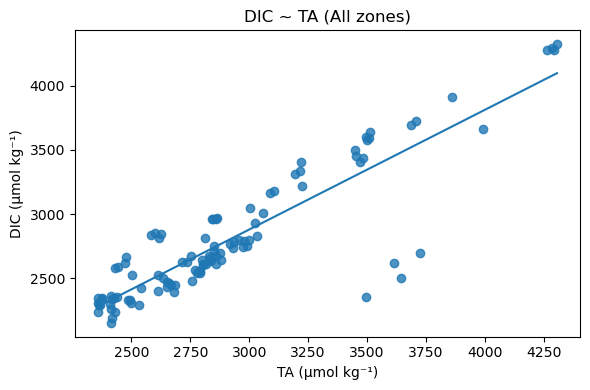

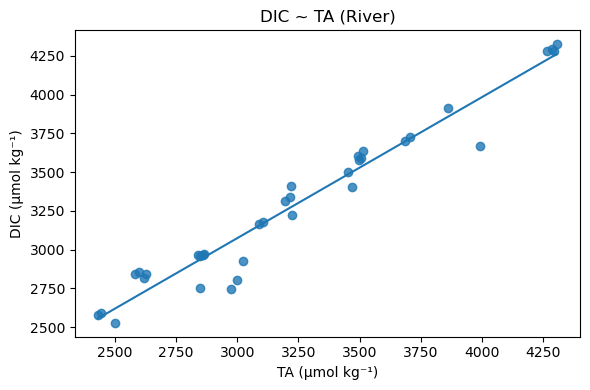

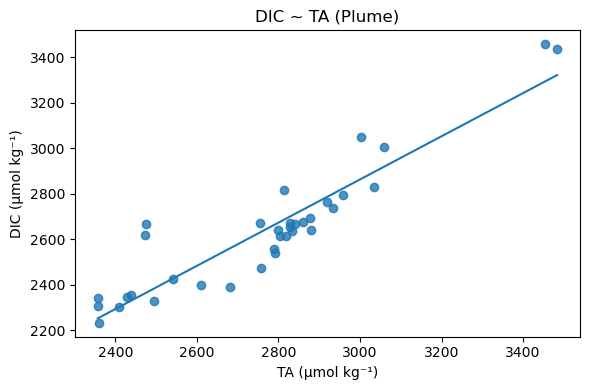

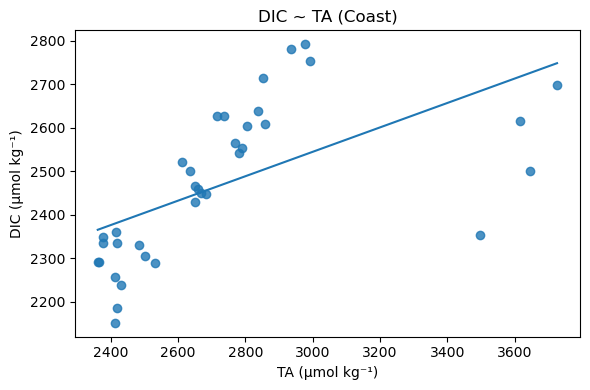

In [176]:
features = {"x": "ta_micromol_kg", "y": "dic_micromol_kg"}
assert all(f in dfe.columns for f in features.values()), "TA/DIC columns not found."

def fit_and_plot_inline(data, title_suffix):
    X = sm.add_constant(data[features["x"]].astype(float))
    y = data[features["y"]].astype(float)
    m = sm.OLS(y, X).fit()
    fig = plt.figure(figsize=(6,4))
    plt.scatter(data[features["x"]], data[features["y"]], alpha=0.8)
    xs = np.linspace(data[features["x"]].min(), data[features["x"]].max(), 200)
    ys = m.params["const"] + m.params[features["x"]] * xs
    plt.plot(xs, ys)
    plt.xlabel("TA (µmol kg⁻¹)")
    plt.ylabel("DIC (µmol kg⁻¹)")
    plt.title(f"DIC ~ TA {title_suffix}")
    plt.tight_layout()
    show_or_save(fig, None) 
    return m

# Global
m_global = fit_and_plot_inline(dfe.dropna(subset=list(features.values())), "(All zones)")

# By zone
for z in ["River","Plume","Coast"]:
    sub = dfe[dfe["area"]==z].dropna(subset=list(features.values()))
    if len(sub) >= 5:
        _ = fit_and_plot_inline(sub, f"({z})")


In [177]:
# Spearman correlation + correlation matrix (heatmap) 
num = dfe.select_dtypes(include=[np.number]).copy()
corr = num.corr(method="spearman")
corr.to_csv(OUT/"spearman_corr.csv")

fig = plt.figure(figsize=(8,6))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar(label="Spearman ρ")
plt.title("Spearman Correlation Matrix")
plt.tight_layout()
fig.savefig(OUT/"spearman_corr.png", dpi=300); plt.close(fig)


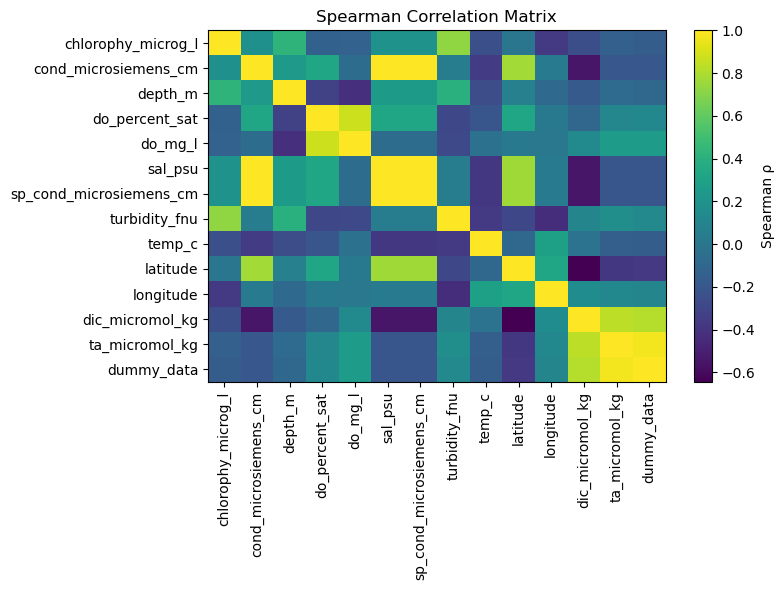

In [178]:
# Spearman matrix 
num = dfe.select_dtypes(include=[np.number]).copy()
if num.shape[1] >= 2 and len(num) >= 3:
    corr = num.corr(method="spearman")
    fig = plt.figure(figsize=(8,6))
    plt.imshow(corr, aspect="auto")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar(label="Spearman ρ")
    plt.title("Spearman Correlation Matrix")
    plt.tight_layout()
    show_or_save(fig, "spearman_corr.png")
else:
    print("Not enough numeric data for Spearman plot.")

In [179]:
#  Factor Analysis (FA) 
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

fa_vars = [v for v in [
    "sal_psu","temp_c","dic_micromol_kg","ta_micromol_kg",
    "do_mg_l","turbidity_fnu","cond_microsiemens_cm","sp_cond_microsiemens_cm",
    "chlorophy_microg_l","depth_m"
] if v in dfe.columns]

X = dfe[fa_vars].dropna()
idx = X.index
Xs = StandardScaler().fit_transform(X.values)

n_factors = 2
fa = FactorAnalysis(n_components=n_factors, random_state=42)
Z = fa.fit_transform(Xs)

# Loadings (variables x factors); communalities = sum of squared loadings per variable
loadings = pd.DataFrame(fa.components_.T, index=fa_vars, columns=[f"F{i+1}" for i in range(n_factors)])
communalities = pd.DataFrame({"communalities": (loadings**2).sum(axis=1)}, index=fa_vars)

loadings.to_csv(OUT/"fa_loadings.csv")
communalities.to_csv(OUT/"fa_communalities.csv")

# Biplot-like scatter of factor scores (F1 vs F2), colored by estuary (2 groups)
fig = plt.figure(figsize=(6,5))
est = dfe.loc[idx, "estuary"].values
for label in ["Candelaria","Palizada"]:
    m = est == label
    plt.scatter(Z[m,0], Z[m,1], alpha=0.8, label=label)
plt.legend()
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")
plt.title("Factor Analysis scores (F1 vs F2)")
plt.tight_layout()
fig.savefig(OUT/"fa_scores.png", dpi=300); plt.close(fig)


In [180]:
# PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_vars = [v for v in [
    "sal_psu","temp_c","dic_micromol_kg","ta_micromol_kg","do_mg_l","turbidity_fnu"
] if v in dfe.columns]

X = dfe[pca_vars].dropna()
idx = X.index
Xs = StandardScaler().fit_transform(X.values)

pca = PCA(n_components=2, random_state=42).fit(Xs)
pcs = pca.transform(Xs)
expl = pca.explained_variance_ratio_

# Scores plot by estuary
fig = plt.figure(figsize=(6,5))
est = dfe.loc[idx,"estuary"].values
for label in ["Candelaria","Palizada"]:
    m = est==label
    plt.scatter(pcs[m,0], pcs[m,1], alpha=0.8, label=label)
plt.legend()
plt.xlabel(f"PC1 ({expl[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({expl[1]*100:.1f}%)")
plt.title("PCA (first two components)")
plt.tight_layout()
fig.savefig(OUT/"pca_scores.png", dpi=300); plt.close(fig)

# Loadings
loadings = pd.DataFrame(pca.components_.T, index=pca_vars, columns=["PC1","PC2"])
loadings.to_csv(OUT/"pca_loadings.csv")


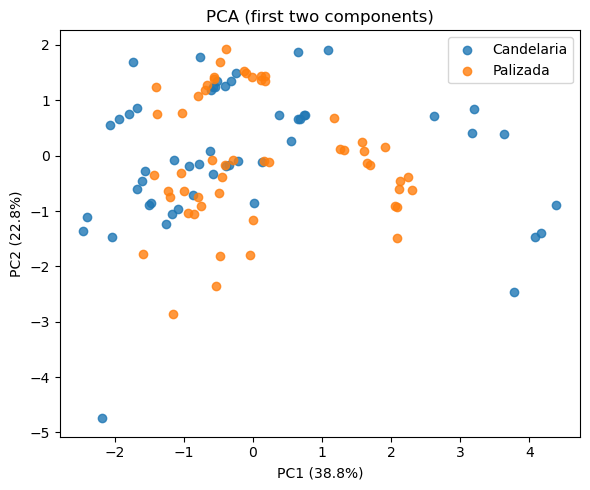

In [181]:

if X.shape[1] >= 2 and len(X) >= 3:
    idx = X.index
    Xs = StandardScaler().fit_transform(X.values)
    pca = PCA(n_components=2, random_state=42).fit(Xs)
    pcs = pca.transform(Xs)
    expl = pca.explained_variance_ratio_

    fig = plt.figure(figsize=(6,5))
    est = dfe.loc[idx,"estuary"].values
    for label in ["Candelaria","Palizada"]:
        m = (est == label)
        plt.scatter(pcs[m,0], pcs[m,1], alpha=0.8, label=label)
    plt.legend()
    plt.xlabel(f"PC1 ({expl[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({expl[1]*100:.1f}%)")
    plt.title("PCA (first two components)")
    plt.tight_layout()
    show_or_save(fig, "pca_scores.png")
else:
    print("Not enough data for PCA.")


In [182]:
# Hierarchical clustering (Ward) + K-means 
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans

clu_vars = [v for v in [
    "sal_psu","temp_c","dic_micromol_kg","ta_micromol_kg","do_mg_l","turbidity_fnu"
] if v in dfe.columns]

Xs = StandardScaler().fit_transform(X.values)

# Hierarchical (Ward) dendrogram
Z = linkage(Xs, method="ward")
fig = plt.figure(figsize=(8,4))
dendrogram(Z, no_labels=True, count_sort=True)
plt.title("Hierarchical clustering (Ward) — dendrogram")
plt.tight_layout()
fig.savefig(OUT/"cluster_dendrogram_ward.png", dpi=300); plt.close(fig)

# K-means (k=3) on standardized features (didactic)
k = 3
km = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = km.fit_predict(Xs)

# Scatter using the first two variables
fig = plt.figure(figsize=(6,5))
plt.scatter(Xs[:,0], Xs[:,1], alpha=0.8, c=labels)  
plt.title("K-means (k=3) on standardized features")
plt.xlabel(clu_vars[0]); plt.ylabel(clu_vars[1])
plt.tight_layout()
fig.savefig(OUT/"kmeans_scatter.png", dpi=300); plt.close(fig)

# Save labels with metadata
out_df = dfe.loc[X.index, ["estuary","area"]].copy()
out_df["kmeans_k3"] = labels
out_df.to_csv(OUT/"kmeans_labels.csv", index=False)


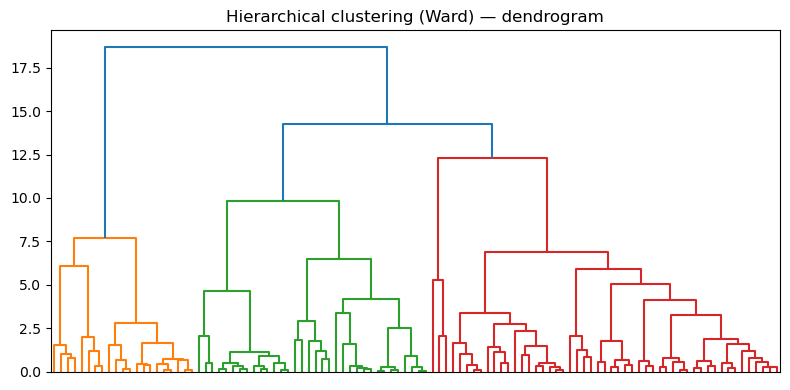

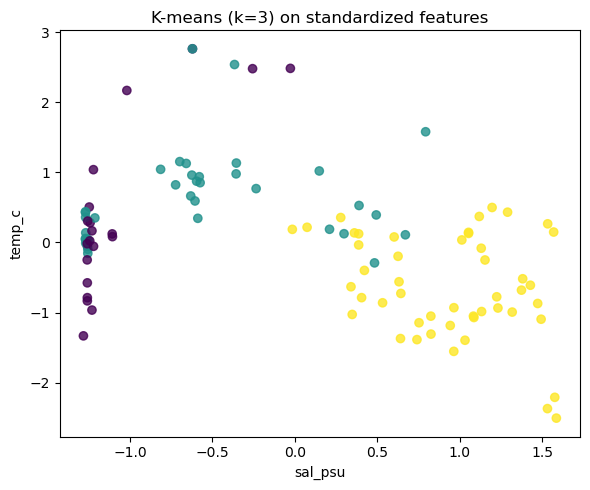

In [183]:

clu_vars = [v for v in ["sal_psu","temp_c","dic_micromol_kg","ta_micromol_kg","do_mg_l","turbidity_fnu"] if v in dfe.columns]
Xc = dfe[clu_vars].dropna()
if Xc.shape[1] >= 2 and len(Xc) >= 3:
    Xcs = StandardScaler().fit_transform(Xc.values)

    # Dendrogram (Ward)
    Z = linkage(Xcs, method="ward")
    fig = plt.figure(figsize=(8,4))
    dendrogram(Z, no_labels=True, count_sort=True)
    plt.title("Hierarchical clustering (Ward) — dendrogram")
    plt.tight_layout()
    show_or_save(fig, "cluster_dendrogram_ward.png")

    # K-means (k=3)
    k = 3
    labels = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(Xcs)
    fig = plt.figure(figsize=(6,5))
    plt.scatter(Xcs[:,0], Xcs[:,1], alpha=0.8, c=labels)
    plt.title("K-means (k=3) on standardized features")
    plt.xlabel(clu_vars[0]); plt.ylabel(clu_vars[1])
    plt.tight_layout()
    show_or_save(fig, "kmeans_scatter.png")
else:
    print("Not enough data for clustering.")


In [184]:
# Inline plots policy & helper 
SHOW_FIGS = True      
SAVE_FIGS = False     

def show_or_save(fig, name=None):
    """Show plots inline; optionally save PNGs."""
    if SHOW_FIGS:
        plt.show()
    if SAVE_FIGS and name is not None:
        fig.savefig(OUT / name, dpi=300, bbox_inches="tight")
    plt.close(fig)


## Results 

My goal was to compare Candelaria vs Palizada within each zone (River, Plume, Coast) and decide on the right tests based on assumptions.

- Assumption checks: In the River zone, normality was often not achieved and variances sometimes differed, so I defaulted to Mann–Whitney with Cliff’s δ. In Plume and Coast, variances were generally homogeneous; when both groups passed Shapiro I used t-tests (equal or Welch), otherwise I kept Mann–Whitney. The “recommended_test” table documents each decision.

- Estuary contrasts by zone: I ran Candelaria vs Palizada comparisons for salinity, temperature, DIC and TA within each zone. River mostly required non-parametric tests; in Plume and Coast, several variables were fine for t-tests. (Salinity differences in River and Coast were especially clear.)

- Two-way ANOVA (temp_c ~ estuary × area): Residuals were approximately normal (Shapiro p ≈ 0.121), but Levene across cells indicated heteroscedasticity (p ≈ 0.0068); I report the classical ANOVA and complement inference with robust (HC3) OLS.

- Linear relation: DIC and TA showed a strong positive association (globally and within zones), consistent with mixing-driven carbonate variability.

- Correlation structure: The Spearman matrix showed coherent hydrographic patterns across variables.

- Multivariate view: PCA arranged samples along a hydrographic/carbonate gradient, and a simple K-means (k = 3) partitioned the data in a way that matches those gradients.



## References
Bach, L., Calderon, R., Cepeda, M. F., Oczkowski, A., Olsen, S. B., & Robadue, D. (2005). Resumen del Perfil de Primer Nivel del Sitio Laguna de Términos y su Cuenca, México. Coastal Resources Center, University of Rhode Island.

Kennish, M. J. (2002). Environmental threats and environmental future of estuaries. Environmental Conservation, 29(1), 78–107).

McKinney, W. (2010). Data structures for statistical computing in Python. In S. van der Walt & J. Millman (Eds.), Proceedings of the 9th Python in Science Conference (SciPy 2010) (pp. 51–56).

Virtanen, P., et al. (2020). SciPy 1.0: Fundamental algorithms for scientific computing in Python. Nature Methods, 17, 261–272.

Seabold, S., & Perktold, J. (2010). Statsmodels: Econometric and statistical modeling with Python. In Proceedings of the 9th Python in Science Conference (SciPy 2010).

Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825–2830.

Zar, J. H. (2010). Biostatistical analysis (5th ed.). Pearson.

Sokal, R. R., & Rohlf, F. J. (1995). Biometry (3rd ed.). W. H. Freeman.
